# The OK Anomaly

This notebook looks at seismic data from a series of seismic anomalies recorded in Oklahoma and Texas during the spring and summer of 2019. It follows up on a story in National Geographic: [_Mysterious waves have been pulsing across Oklahoma_](https://www.nationalgeographic.com/science/2019/09/strange-waves-rattled-entire-state-scientists-know-why/), which itself references the post [_An acoustic anomaly_](https://okgeosurvey.wordpress.com/2019/07/25/an-acoustic-anomaly/) on the Oklahoma Geological Survey blog.

Note that you will need to [install ObsPy](https://github.com/obspy/obspy/wiki/Installation-via-Anaconda) to run this notebook on your own system.


## Get the data

Let's start with the data presented in the seismogram from the OGS blog post.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from obspy.clients.fdsn import Client
client = Client("IRIS")

I'm just following the [instructions in the ObsPy documentation](https://docs.obspy.org/packages/obspy.clients.fdsn.html).

The event was at about 11:11 am local (surely [not a coincidence?](https://en.wikipedia.org/wiki/Armistice_of_11_November_1918)), and I'm going to grab a 45 minutes of data:

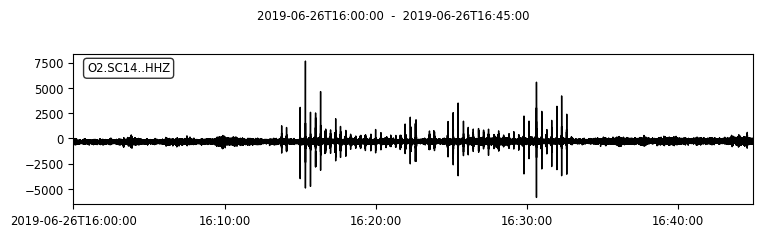

In [3]:
from obspy import UTCDateTime

t = UTCDateTime("2019-06-26_16:00:00")
st = client.get_waveforms("O2", "SC14", "*", "HHZ", t, t + 1*45*60)

st.plot()  

Let's have a look at another station, e.g. SC16. Turns out the signal is there, but a little buried in noise. The same early pulse is there too; could that be a seismic (as opposed to acoustic) signal?

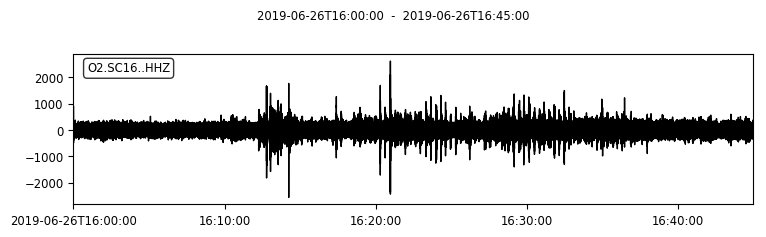

In [4]:
from obspy import UTCDateTime
t = UTCDateTime("2019-06-26_16:00:00")
st_ = client.get_waveforms("O2", "SC16", "*", "HHZ", t, t + 1*45*60)
st_.filter('bandpass', freqmin=0.7, freqmax=20)

st_.plot()  

What's **HHZ**? Seismic stations have lots of instruments and make their waveforms availables as various different channels, depending on the station. For example:
    
- `LHZ`: long period ~1 Hz, with `Z` for vertical, or `N` or `E` for horizontal.
- `BHZ`: broadband 10–80 Hz, with `Z` for vertical, or `N` or `E` for horizontal.
- `HHZ`: broadband 80–250 Hz, with `Z` for vertical, or `N` or `E` for horizontal.
- Some stations have loads of others, see Appendix A in [the SEED Manual](http://www.fdsn.org/seed_manual/SEEDManual_V2.4.pdf).

## Listen to the signal

Returning to the original signal:

In [5]:
st

1 Trace(s) in Stream:
O2.SC14..HHZ | 2019-06-26T16:00:00.000000Z - 2019-06-26T16:45:00.000000Z | 100.0 Hz, 270001 samples

In [6]:
st.traces[0]

O2.SC14..HHZ | 2019-06-26T16:00:00.000000Z - 2019-06-26T16:45:00.000000Z | 100.0 Hz, 270001 samples

In [7]:
st.traces[0].data

array([-337, -353, -360, ..., -552, -366, -213], dtype=int32)

In [8]:
sig = st.traces[0].data
Fs = st.traces[0].meta.sampling_rate

We'll use `IPython` to 'display' the array as audio, multiplying the sample interval by 60 to speed it up by that factor &mdash; so one minute of data lasts one second on this recording. That way, your computer might be able to reproduce it, and we might be able to hear it.

In [9]:
import IPython.display as ipd

ipd.Audio(sig, rate=Fs*60)

We can also write a WAV file:

In [10]:
import numpy as np
from scipy.io import wavfile

N = int(Fs*60) # Samples per second
wavfile.write('../data/ok-anomaly.wav', N, sig.astype(np.int16))

ipd.Audio('../data/ok-anomaly.wav')

## Where is the station?

ObsPY is pretty cool. It can draw a map showing us where stations and events are.

Note that to do this you need `basemap` and `cartopy`:

    conda install basemap
    conda install cartopy

In [11]:
inventory = client.get_stations(network="O2", station="SC14")
inventory

Inventory created at 2019-09-15T12:50:26.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.37
		    http://service.iris.edu/fdsnws/station/1/query?network=O2&station=SC14
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			O2
		Stations (1):
			O2.SC14 (Walters, Oklahoma, USA)
		Channels (0):


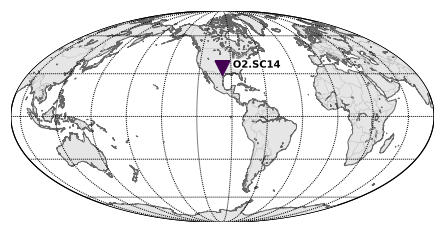

In [12]:
inventory.plot(projection='global', color=0.15)
plt.show()

We can look for more stations in the network:

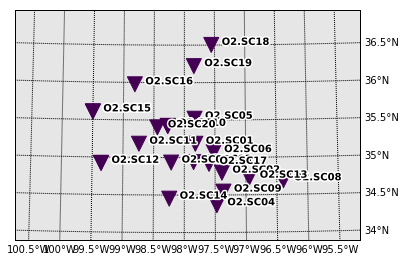

In [13]:
client = Client("IRIS")

inventory = client.get_stations(network="O2", station="SC*")

inventory.plot(projection='local', color=0.15)
plt.show()

In [14]:
inventory

Inventory created at 2019-09-15T12:50:29.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.37
		    http://service.iris.edu/fdsnws/station/1/query?network=O2&station=S...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			O2
		Stations (23):
			O2.SC01 (Tuttle, Grady County, OK, USA)
			O2.SC02 (Maysville, Garvin & McClain Counties, OK, USA)
			O2.SC03 (Ninnekah, Oklahoma, USA)
			O2.SC04 (Fox, Oklahoma, USA)
			O2.SC05 (El Reno, Oklahoma, USA)
			O2.SC06 (Washington, Oklahoma, USA)
			O2.SC07 (Cyril, Oklahoma, USA)
			O2.SC08 (Tupelo, Oklahoma, USA)
			O2.SC09 (Elmore City, Oklahoma, USA)
			O2.SC10 (Scott, Oklahoma, USA) (2x)
			O2.SC11 (Cordell, Oklahoma, USA)
			O2.SC12 (Granite, Oklahoma, USA) (2x)
			O2.SC13 (Stratford, Oklahoma, USA)
			O2.SC14 (Walters, Oklahoma, USA)
			O2.SC15 (Hammon, Oklahoma, USA) (2x)
			O2.SC16 (Oakwood, Oklahoma, USA)
			O2.SC17 (Lindsey, Oklahoma, USA)
			O2.SC18 (Garber, Oklahoma, USA)
			O2.SC19 (Bison, Oklahom

## Make a spectrogram

The ObsPy stream object contains all our data:

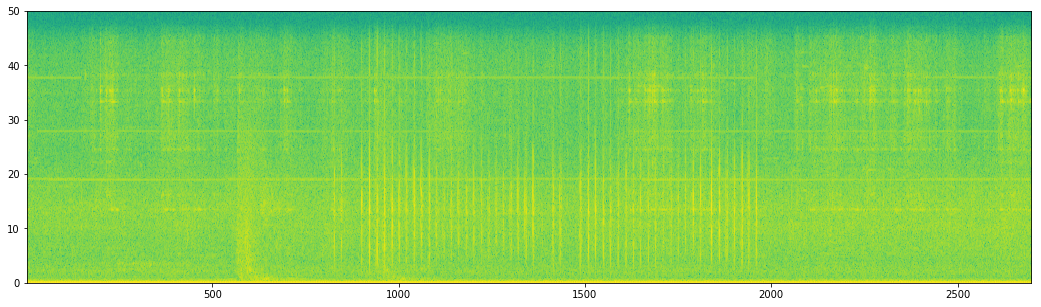

In [15]:
plt.figure(figsize=(18, 5))
NFFT = 512
_ = plt.specgram(sig, Fs=Fs, NFFT=NFFT, noverlap=int(0.9*NFFT))

A slightly fancier plot:

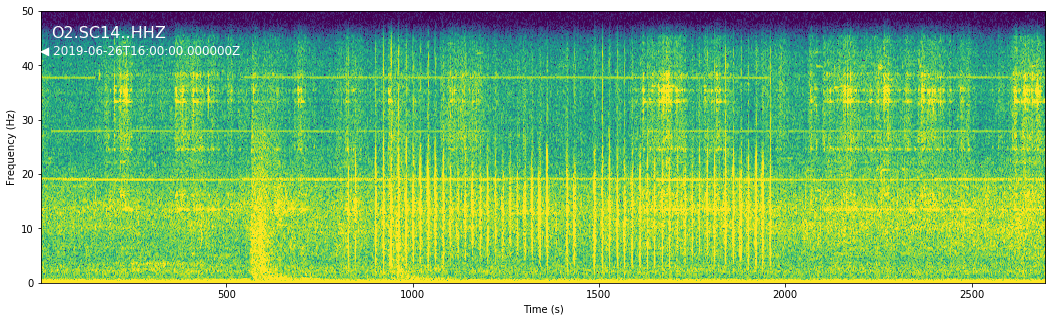

In [16]:
label = "{network}.{station}.{location}.{channel}".format(**st.traces[0].meta)

plt.figure(figsize=(18, 5))
Pxx, freqs, bins, im = plt.specgram(sig, Fs=Fs,
                                    NFFT=NFFT, noverlap=int(0.9*NFFT),
                                    vmin=-30, vmax=30,)
plt.text(30, 45, label, size=16, color='white')
plt.text(0, 42, "◀ " + str(t), size=12, color='white')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

I don't know what those persistent monotonic noises are, like the one at 19 Hz (and its harmonic at 38 Hz). Any ideas?

<hr>

**&copy; 2019 [agilescientific.com](https://www.agilescientific.com/) and licensed [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)**